# Home Assignment No. 2 ( Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

# Task 2. MRI T1 image segmentation (15 points)

#### To get maximum points you are to:
-  1. Attach your working notebook in `hw2` archive **(2 pts)**
-  2. Attach the trained model with model.state_dict and provide the code for prediction below **(2 pts)**
-  3. Write an abstract what experiments, validation setups, and fine-tunings brought you to the best DICE score **(2 pts)**
-  4. Segment `100206, 100307, 100408` patients with `DICE score > 0.9` for the defined list of brain regions **(4 pts)**
- 5. Create and save a panel with a view in Comet or W&B or Tensorbord. It should be super nice. **(5 pts)**


 * **Extra points**: best result `Surface Distance Metrics` **(5 pts)**

To get the `norm.nii` files from `*.mgz` for these three patients I've entered the `docker container` from `Seminar 2` 
https://github.com/adasegroup/NEUROML2021/tree/master/seminar2

And in `freesurfer environement` convert `*.mgz` files to `*.nii` files. You can use the following script:

```   ### path: path to folder with subject to process
      ### basename: root path

      # saving names for normalised and aseg files
      F_NORM="$(find $path/mri/ -name "*norm.mgz")";
      F_PARC="$(find $path/mri/ -name "*aparc+aseg.mgz")";
      
      # echo "$F_NORM file $2/$(basename $1)_$(basename $path)_norm.nii.gz" 
      # echo "$F_PARC file $2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz"

      # converting files to needed format
      mri_convert -it "mgz" -ot "nii" "$F_NORM" "$2/$(basename $1)_$(basename $path)_norm.nii.gz";
      mri_convert -it "mgz" -ot "nii" "$F_PARC" "$2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz";
```        

See documentation: https://surfer.nmr.mgh.harvard.edu/fswiki/mri_convert

Yeah, we already did it for you. And now you have the ground truth to compare your result in `/fs_segmentation/`. 
**Please do not cheat with it**: either pretraining model or in any other way using the ground truth for your prediction. 

## Part 2: provide the code for prediction below (2 pts)

In [2]:
### BEGIN Solution
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unet import UNet


if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

    
# FIX SAME SEED AS IN SOLUTION
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# this model has better hausdorf metrics: final_model_dir = './logs/focal_loss_6cls_4enc_8out_patch_64batch_crop/model_focal_loss_6_classes_4_blocks_8_chanels.pth'
# this model has better dice score metrics:
final_model_dir = './logs/focal_noschedule_6cls_4enc_8out_patch_64batch_crop_lr=0001_lr=00003/model_focal_noschedule_6_classes_4_blocks_8_chanels.pth'

print('For the full solution please refer to Bobrovskikh_solution.ipynb :)')

### END Solution

For the full solution please refer to Bobrovskikh_solution.ipynb :)


In [3]:
from torchio import AFFINE, DATA, PATH, TYPE, STEM

CHANNELS_DIMENSION = 6
SPATIAL_DIMENSIONS = 2, 3, 4

VENTRCL =  [4,5,15,43,44,72]# 1
BRN_STEM = [16] # 2
HIPPOCMPS = [17, 53] # 3
AMYGDL = [18, 54] # 4
GM = [1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
       1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
       2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035] # 5

LABELS = VENTRCL + BRN_STEM + HIPPOCMPS + AMYGDL + GM # all of interest


def prepare_aseg(targets):
    """
    The function binarises the data  with the LABEL list.
   """
    targets = np.where(np.isin(targets, LABELS, invert = True), 0, targets)
    targets = np.where(np.isin(targets, VENTRCL), 1, targets)
    targets = np.where(np.isin(targets, BRN_STEM), 2, targets)
    targets = np.where(np.isin(targets, HIPPOCMPS), 3, targets)
    targets = np.where(np.isin(targets, AMYGDL), 4, targets)
    targets = np.where(np.isin(targets, GM), 5, targets)


    return targets

In [4]:
def get_model_and_optimizer(device, num_encoding_blocks=4, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    model = UNet(
          in_channels=1,
          out_classes=6,
          dimensions=3,
          num_encoding_blocks=num_encoding_blocks,
          out_channels_first_layer=out_channels_first_layer,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='PReLU',
      ).to(device)
      
    optimizer = torch.optim.AdamW(model.parameters())
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

# model, optimizer, scheduler = get_model_and_optimizer(0)

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

### Part 3: write an abstract what experiments, validation setups,and fine-tunings brought you to the best DICE score **(2 pts)**

<font color='green'> Place for your abstract.</font>

To achieve best DICE score I have conducted the following experiments:
* **baseline**: 3D UNet with 4 encoding blocks, 8 output features in the first UNet block, `AdamW` optimizer was used with initial learning rate equal to 0.001 and learning rate scheduler `ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.01)`. Baseline average test DICE <font color='green'>  score = 0.946 </font>. 

* **augmentations:**
    * **augmentations set #1:** I have picked augmentations from [torchio library](https://torchio.readthedocs.io/transforms/augmentation.html#torchio.transforms.RandomAffine) as it provides "task-driven" augmentations that represent real noise from MRI scanners. For the first experiment I picked all MRI specific augmentations and some additional standard augmentations like blur and random noise. Full list here:
    ```
    my_transforms = [transforms.RandomGamma(log_gamma=(-0.3, 0.3)),
                     transforms.RandomBiasField(),
                     transforms.RandomMotion(),
                     transforms.RandomGhosting(),
                     transforms.OneOf({transforms.RandomNoise(): 0.5, 
                                       transforms.RandomBlur(): 0.5}] 

    ```
    I have trained similar to baseline model with similar scheme (optimizer + scheduler).
    
    This experimed, unfortunately, showed worse results that baseline version, the validation score ended up with the best result equal to 0.92. I decided to check also some more traditional augmentations as random flips and affine transforms in the next experiment. 
    
    * **augmentations set #2:** I also tried another set of augmentations:
    ```
    my_transforms = [torchio.transforms.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
                     torchio.transforms.RandomAffine(),
                     transforms.RandomGamma(log_gamma=(-0.3, 0.3)),
                     transforms.RandomBiasField(),
                     transforms.RandomMotion(),
                     transforms.RandomGhosting(),
                     transforms.RandomNoise(mean=0, std=(0, 3)),
                     transforms.RandomBlur(std=(0, 1))]
    ```
    For this larger set of augmentations I decided to expand neural network feature space by increasing amount of features in the UNet encoder: 8 output features --> 32 output features. Optimizer, learning rate and scheduling remained similar to the previous experiment. This set of augmentations didn't improve previous results. Best validation score was still around 0.92. So, I decided that probably in this case MRI artifacts are not vastly presented in this dataset and therefore augmentations won't make model learn segmentation better.
    
* **loss functions:**
    * **focal loss:**
    Focal loss was presented in [paper](https://arxiv.org/pdf/1708.02002.pdf) as a solution for class imbalance problem. It's main idea is to focus neural network learning on more complicated classes which have low probability of correct class. Originaly, focal loss was proposed for binary classification, but there are extensions to multi-class problem. So, I have implemented multi-class focal loss for our segmentation class and tried it in the following experiments. This loss has two hyperparameters: gamma which is a power of inversed class predicted probability and alpha which weight loss value for each class.
        * **basic:** In this experiment I used 3D Unet with 4 encoding blocks, 8 output features in the first UNet block, AdamW optimizer with initial lr=0.001 and reduce_on_plate scheduler. In focal loss I used alpha equal to 1. for each class, so that I excluded it from the loss computation. And I tried different gamma values and ended up with gamma=0.2 which is showed in original paper to have a significant effect on the NNs training. I trained my network for 100 epochs and it converged to the best score in ~ 20 epochs and it's test DICE <font color='green'> score = 0.947 </font>. This score seems to outperform baseline model with score 0.946.
        * **different scheduler:** In this experiment I decided to train my network with similar focal loss as in the previous setup but I decided to check whether it is better to drop learning rate after greater epoch than reduce_on_plateau does. So I trained my network with similar AdamW optimizer and lr=0.001 until it remained on plateau for ~10 epoches. I was waiting maybe it will start overfitting however graphics didn't show evidences of overfitting. So after ~50 epoches I dropped lr to 0.0001. After that I trained network for additional 10 epoches and it reached average validation dice score <font color='red'> 0.95 </font>. After that I reduced lr more and trained network with lr=0.00003 for some more time. Score didn't improve much so I decided to stop. I wanted to wrap this procedure to LinearScheduler but I didn't have time so I left this experiment as described. 
    * **tversky loss:**
    Tversky (focal) loss was proposed in [paper](https://arxiv.org/pdf/1810.07842.pdf) to deal with class imbalance in medical images segmentation. This loss uses Tversky index which looks similar to Dice Index but with weights for False Positive and False Negative predictions. In my loss function I used one alpha value to weight these two prediction types: alpha for False Positive and (1-alpha) for False Negative. This index is inversed to represent a loss value and got to the power of gamma, which is another hyperparameter (derived fromm focal loss definition). 
        * **alpha=0.3:** I used Tversky loss with alpha=0.3 so that False Positives would be weighted with alpha and False Negatives with (1-alpha) and other setup parameters (network, optimizer and lr schedule are set similar to focal loss basic experiment). This experiment resulted in the average test <font color='green'> score = 0.947 </font> with similar best average score on validation. This score seems to outperform baseline model with score 0.946.
        * **with augmentations:** I also tried to carry out experiment with this loss and increased amount of data, but it didn't imrove results from the previous experiment with Tversky loss. An augmentation set was used from the experiment "augmentations set #2". 

### Part 4: segment 100206, 100307, 100408 patients with DICE score > 0.9 for the defined list of brain regions (4 points)

*Please be sure, you we training on the same labels `LIST_ASEG`*:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

## Test subjects:

In [8]:
### BEGIN Solution

import torchio 
import enum
"""
    Code adapted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO: 
        a Python library for efficient loading, preprocessing, 
        augmentation and patch-based sampling of medical images in deep learning.

"""

MRI = 'MRI'
LABEL = 'LABEL'

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(inputs, targets, transform):
    """
    The function creates dataset from the list of files from cunstumised dataloader.
    """
    subjects = []
    for (image_path, label_path) in zip(inputs, targets):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    
    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)
    
    return dataset, subjects


# LOAD MY MODEL FROM CHECKPOINT

model, optimizer, scheduler = get_model_and_optimizer(0)
model.load_state_dict(torch.load(final_model_dir))

### END Solution

<All keys matched successfully>

In [9]:
test_subjects = [100206, 100307, 100408]
test_norm_dir = './test'

testing_data_list = pd.DataFrame({
    'Subject': test_subjects,
    'norm': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_norm.nii.gz' for subject in test_subjects],
    'aseg': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_aparc+aseg.nii.gz' for subject in test_subjects]
})



testing_data, testing_subjects = get_torchio_dataset(testing_data_list['norm'], testing_data_list['aseg'], False)
testing_set = torchio.SubjectsDataset(testing_subjects)
testing_data_list.head()

,Subject,norm,aseg
0,100206,./test/HCP_T1_fs6_100206_norm.nii.gz,./test/HCP_T1_fs6_100206_aparc+aseg.nii.gz
1,100307,./test/HCP_T1_fs6_100307_norm.nii.gz,./test/HCP_T1_fs6_100307_aparc+aseg.nii.gz
2,100408,./test/HCP_T1_fs6_100408_norm.nii.gz,./test/HCP_T1_fs6_100408_aparc+aseg.nii.gz


In [10]:
# OLD SOLUTION
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
# else:
#     device = torch.device("cpu")
    
# model.load_state_dict(torch.load('models/model_6_classes_4_blocks_8_chanels.pth'))

In [11]:
# !git clone https://github.com/deepmind/surface-distance.git
# !pip install surface-distance/
from surface_distance import metrics

In [12]:
def validate(label, pred):
    ''' Computes DICE and Hausdorf95 measures
    '''

    test_res = pd.DataFrame(columns = ['DICE_1', 'DICE_2', 'DICE_3', 'DICE_4', 'DICE_5',
                                      'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3', 'Hausdorff95_4', 'Hausdorff95_5'])
    # class 1
    distances = metrics.compute_surface_distances((label[0] == 1), (pred[0].numpy() == 1), [1,1,1])
    test_res.at[0,'DICE_1'] = metrics.compute_dice_coefficient((label[0] == 1), (pred[0].numpy() == 1))
    test_res.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 2
    distances = metrics.compute_surface_distances((label[0] == 2), (pred[0].numpy() == 2), [1,1,1])
    test_res.at[0,'DICE_2'] = metrics.compute_dice_coefficient((label[0] == 2), (pred[0].numpy() == 2))
    test_res.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 3
    distances = metrics.compute_surface_distances((label[0] == 3), (pred[0].numpy() == 3), [1,1,1])
    test_res.at[0,'DICE_3'] = metrics.compute_dice_coefficient((label[0] == 3), (pred[0].numpy() == 3))
    test_res.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 4
    distances = metrics.compute_surface_distances((label[0] == 4), (pred[0].numpy() == 4), [1,1,1])
    test_res.at[0,'DICE_4'] = metrics.compute_dice_coefficient((label[0] == 4), (pred[0].numpy() == 4))
    test_res.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 5
    distances = metrics.compute_surface_distances((label[0] == 5), (pred[0].numpy() == 5), [1,1,1])
    test_res.at[0,'DICE_5'] = metrics.compute_dice_coefficient((label[0] == 5), (pred[0].numpy() == 5))
    test_res.at[0,'Hausdorff95_5'] = metrics.compute_robust_hausdorff(distances, 95)
    
    return test_res

##### Predicting subjects `100206`, `100307`,`100408`:

In [ ]:
# best dice score achieved with model trained with linearly dropped lr after fixed number of iterations

/opt/conda/lib/python3.6/site-packages/torchio/data/inference/aggregator.py:165: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


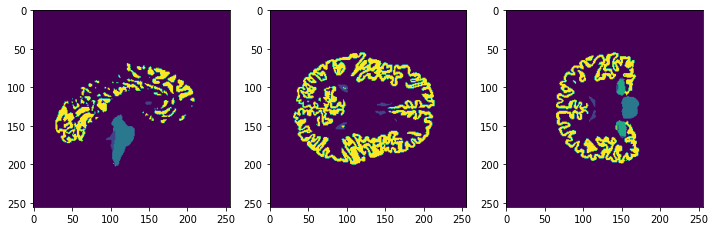

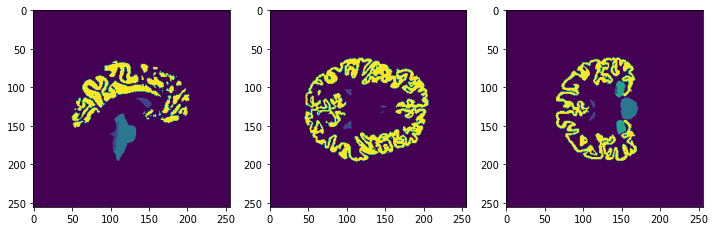

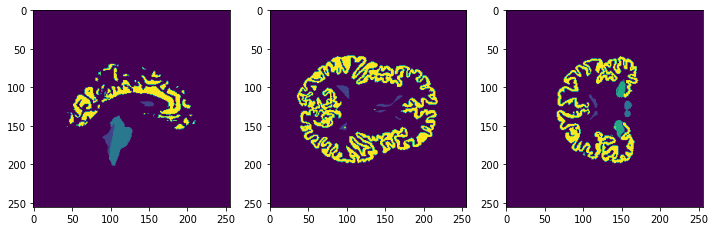

,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,Hausdorff95_1,Hausdorff95_2,Hausdorff95_3,Hausdorff95_4,Hausdorff95_5
0,0.924428,0.964467,0.926112,0.904479,0.958728,1,1,1,1,0
1,0.922288,0.948072,0.92503,0.902859,0.954918,1,1.73205,1,1,1
2,0.931585,0.965828,0.916667,0.897446,0.951714,1,1,1,1,1


In [13]:
res_pivot = pd.DataFrame()
for i in range(0, len(testing_set)):
    sample = testing_set[i]
    patch_size = 64, 64, 64 
    patch_overlap = 20
    grid_sampler = torchio.inference.GridSampler(
        sample,
        patch_size,
        patch_overlap,
    )
    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=8)
    aggregator = torchio.inference.GridAggregator(grid_sampler)

    model.eval()
    with torch.no_grad():
        for patches_batch in patch_loader:
            inputs = patches_batch[MRI][DATA].to(device)
            locations = patches_batch['location']
            logits = model(inputs.float())
            labels = logits.argmax(dim=1, keepdim=True)
            aggregator.add_batch(labels, locations)
            
            
    pred = aggregator.get_output_tensor()
    label = prepare_aseg(testing_set[i][LABEL][DATA])
    plot_central_cuts(pred)
    temp_df = validate(label, pred)
    res_pivot = res_pivot.append(temp_df, ignore_index =True)

res_pivot

In [ ]:
# focal loss trained with reduce lr on plateau has better Hausdorff metrics:
final_model_dir = './logs/focal_loss_6cls_4enc_8out_patch_64batch_crop/model_focal_loss_6_classes_4_blocks_8_chanels.pth'

/opt/conda/lib/python3.6/site-packages/torchio/data/inference/aggregator.py:165: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


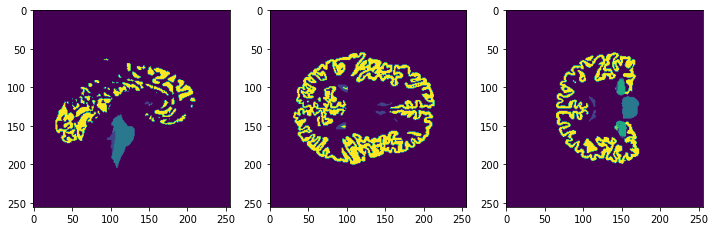

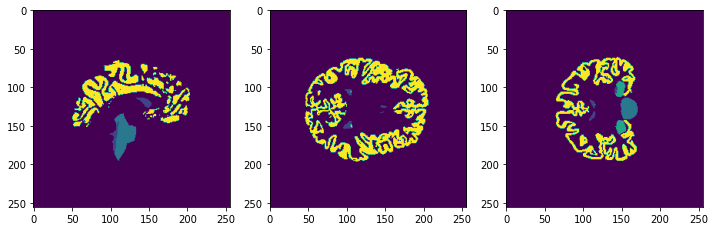

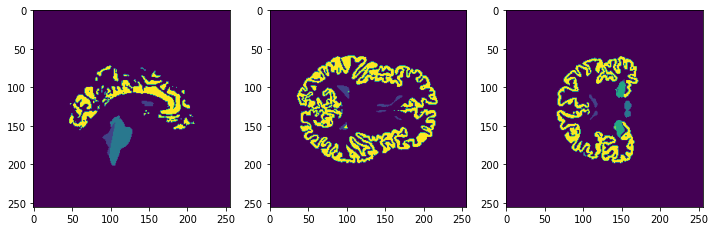

,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,Hausdorff95_1,Hausdorff95_2,Hausdorff95_3,Hausdorff95_4,Hausdorff95_5
0,0.919147,0.961562,0.923201,0.902312,0.953259,1,1,1,1,1
1,0.915669,0.946099,0.919743,0.903808,0.949278,1,1.73205,1,1,1
2,0.928295,0.963128,0.918489,0.892638,0.94744,1,1,1,1,1


In [36]:
res_pivot = pd.DataFrame()
for i in range(0, len(testing_set)):
    sample = testing_set[i]
    patch_size = 64, 64, 64 
    patch_overlap = 20
    grid_sampler = torchio.inference.GridSampler(
        sample,
        patch_size,
        patch_overlap,
    )
    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=8)
    aggregator = torchio.inference.GridAggregator(grid_sampler)

    model.eval()
    with torch.no_grad():
        for patches_batch in patch_loader:
            inputs = patches_batch[MRI][DATA].to(device)
            locations = patches_batch['location']
            logits = model(inputs.float())
            labels = logits.argmax(dim=1, keepdim=True)
            aggregator.add_batch(labels, locations)
            
            
    pred = aggregator.get_output_tensor()
    label = prepare_aseg(testing_set[i][LABEL][DATA])
    plot_central_cuts(pred)
    temp_df = validate(label, pred)
    res_pivot = res_pivot.append(temp_df, ignore_index =True)

res_pivot

### Above is my best model predictions scored ^
### Below there is baseline model predictions presented for comparison:

<img src="./baseline_table.png" alt="Alternative text" />


<font color='red'>Make sure, you are achieving better results, than this baseline either in terms of **DICE**, either **Hausdorff95 distance**.</font>

# Task 2. Comet ML/ W&b report panel (5 points)

Attach here a link to your public experiment in `Comet ML`:
### LINK:
https://www.comet.com/bobrg/segment-brain/view/new/panels

In [41]:
!pwd ./comet_meme.png

/home/neuro-ml-2002


### That's it! Now we can proceed with the suggestion from Comet random log names and have a...

<img src="./comet_meme.png" alt="Alternative text" />


This homework is intended on conducting the small and good experiment with its annotation. 
That is why, the `Comet ML` part is scored the most, so please put more effort into your results representation. 
The best pannel will be graded with **5 extra points.** as well as the most acurate solution.


Yes, you get a full solution it your hands, yet keep in mind - it is just your baseline. You should experiment with the augmentations, losses and build a story of your model development.